<a href="https://colab.research.google.com/github/P202U/Movie_recommend/blob/main/Neural_Collaborative_Filtering_with_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")

100%|██████████| 4.77M/4.77M [00:00<00:00, 6.81MB/s]

Extracting files...


# **Data loading and preprocessing**

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

print(f"TensorFlow version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
Num GPUs Available:  1


In [3]:
ratings_df = pd.read_csv(os.path.join(path, 'ml-100k', 'u.data'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies_df = pd.read_csv(os.path.join(path, 'ml-100k', 'u.item'), sep='|', encoding='latin-1',
                       names=['item_id', 'title', 'release_date', 'video_release_date',
                              'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                              'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                              'Thriller', 'War', 'Western'])
movies_df.head()

,item_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
print(f"Number of users: {ratings_df['user_id'].nunique()}")
print(f"Number of movies: {ratings_df['item_id'].nunique()}")
print(f'Number of ratings: {len(ratings_df)}')
print(f"Rating range: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")

Number of users: 943
Number of movies: 1682
Number of ratings: 100000
Rating range: 1 to 5
Average rating: 3.53


In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [7]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             1682 non-null   int64  
 1   title               1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children            1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

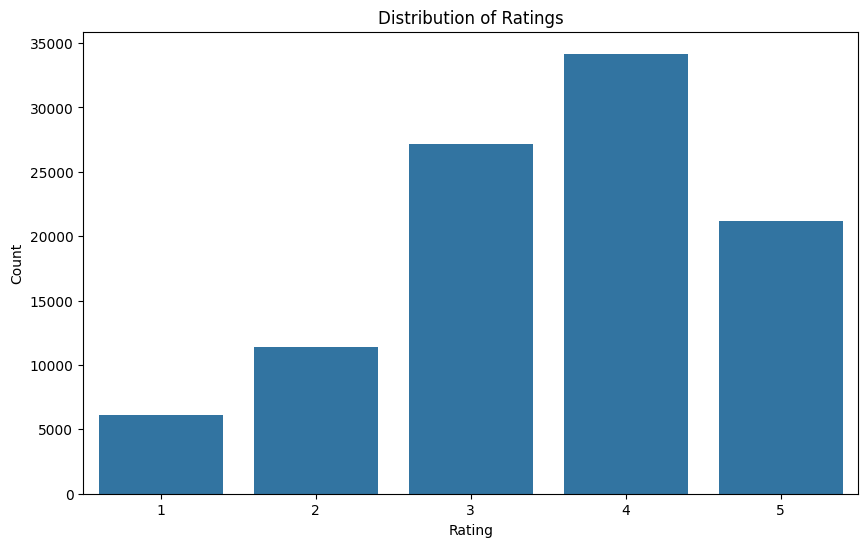

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [9]:
ratings_df['label'] = ratings_df['rating'].apply(lambda x: 1 if x >= 4 else 0)

In [10]:
ratings_df.sample(5)

,user_id,item_id,rating,timestamp,label
75721,877,381,4,882677345,1
80184,815,602,3,878694269,0
19864,94,431,4,891721716,1
76699,416,875,2,876696938,0
92991,500,182,2,883873556,0


# **Data preparation**

In [11]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

print(f"Training: {len(train_df)}")
print(f"Test: {len(test_df)}")

Training: 80000
Test: 20000


In [12]:
num_users = ratings_df['user_id'].max()
num_items = ratings_df['item_id'].max()

print(f"Users: {num_users}")
print(f"Items: {num_items}")

Users: 943
Items: 1682


In [13]:
def create_dataset(df, batch_size=256, train=True):
    ds = tf.data.Dataset.from_tensor_slices((
        {
            "user_id": df['user_id'].values.astype(np.int64),
            "item_id": df['item_id'].values.astype(np.int64)
        },
        df['label'].values.astype(np.float32)
    ))
    if train:
        ds = ds.shuffle(len(df))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
train_loader = create_dataset(train_df)
test_loader = create_dataset(test_df, train=False)

In [16]:
class NCF(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim=32, mlp_layers=[64, 32, 16]):
        super(NCF, self).__init__()

        # GMF Path
        self.user_emb_gmf = layers.Embedding(num_users + 1, embedding_dim, embeddings_initializer='normal')
        self.item_emb_gmf = layers.Embedding(num_items + 1, embedding_dim, embeddings_initializer='normal')

        # MLP Path
        self.user_emb_mlp = layers.Embedding(num_users + 1, embedding_dim, embeddings_initializer='normal')
        self.item_emb_mlp = layers.Embedding(num_items + 1, embedding_dim, embeddings_initializer='normal')

        self.mlp_net = tf.keras.Sequential()
        for units in mlp_layers:
            self.mlp_net.add(layers.Dense(units, activation='relu', kernel_initializer='he_uniform'))

        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        user_ids, item_ids = inputs['user_id'], inputs['item_id']

        # GMF
        gmf_user = self.user_emb_gmf(user_ids)
        gmf_item = self.item_emb_gmf(item_ids)
        gmf_vector = layers.Multiply()([gmf_user, gmf_item])

        # MLP
        mlp_user = self.user_emb_mlp(user_ids)
        mlp_item = self.item_emb_mlp(item_ids)
        mlp_vector = layers.Concatenate()([mlp_user, mlp_item])
        mlp_vector = self.mlp_net(mlp_vector)

        # Combine
        combined = layers.Concatenate()([gmf_vector, mlp_vector])
        return self.output_layer(combined)

model = NCF(num_users, num_items)

In [17]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='ap')]
)

history = model.fit(
    train_loader,
    validation_data=test_loader,
    epochs=10
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - ap: 0.6036 - auc: 0.6513 - loss: 0.6469 - val_ap: 0.7066 - val_auc: 0.7686 - val_loss: 0.5705
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ap: 0.7271 - auc: 0.7932 - loss: 0.5451 - val_ap: 0.7064 - val_auc: 0.7755 - val_loss: 0.5627
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ap: 0.7366 - auc: 0.8096 - loss: 0.5247 - val_ap: 0.7172 - val_auc: 0.7805 - val_loss: 0.5574
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - ap: 0.7696 - auc: 0.8484 - loss: 0.4799 - val_ap: 0.7328 - val_auc: 0.7774 - val_loss: 0.5643
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - ap: 0.8157 - auc: 0.8996 - loss: 0.4119 - val_ap: 0.7167 - val_auc: 0.7703 - val_loss: 0.5801
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ap: 0.8651 - auc: 0.9414 - loss: 0.3331 - val_ap: 0.7183 - val_auc: 0.7622 - val_loss: 0.6138
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ap: 0.9043 - auc: 0.9671 - loss: 0.2647 - val_ap: 0.7137

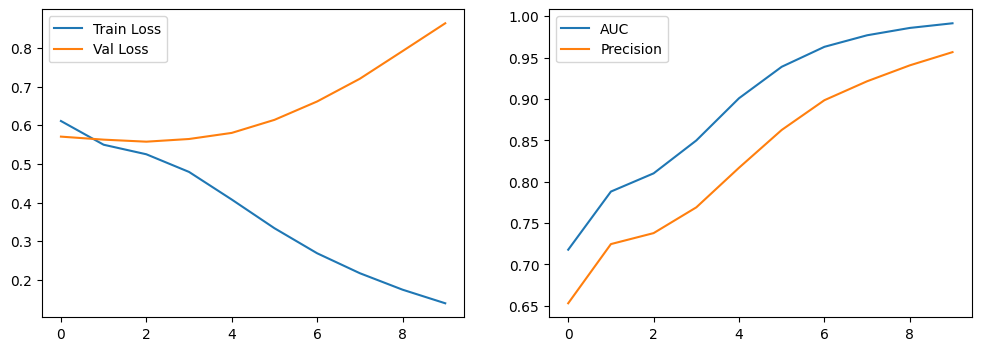

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['ap'], label='Precision')
plt.legend()
plt.show()

model.save_weights('ncf_model.weights.h5')